In [22]:
import os
from results import rate_attacked, attacked_by_bins
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline
import csv
from matplotlib import rcParams
from matplotlib.font_manager import FontProperties
rcParams['font.family'] = 'Times New Roman'
rcParams['figure.figsize'] = (6, 6)

from core.utils_nn import get_model_path, parse_file, parse_pred_file, parse_attack_files
from parse import parse

In [31]:
name = 'histology_thyr_ov_4'
d_f = '../__{}_{}'
l_f = 'H-{}'
ns = [500, 1000, 2000, 5000, 10000, 20000, 50000, 100000]
datasets = []
for n in ns:
    datasets.append({
        'absp': d_f.format(name, n),
        'label': l_f.format(n)
    })

In [32]:
datasets

[{'absp': '../__histology_thyr_ov_4_500', 'label': 'H-500'},
 {'absp': '../__histology_thyr_ov_4_1000', 'label': 'H-1000'},
 {'absp': '../__histology_thyr_ov_4_2000', 'label': 'H-2000'},
 {'absp': '../__histology_thyr_ov_4_5000', 'label': 'H-5000'},
 {'absp': '../__histology_thyr_ov_4_10000', 'label': 'H-10000'},
 {'absp': '../__histology_thyr_ov_4_20000', 'label': 'H-20000'},
 {'absp': '../__histology_thyr_ov_4_50000', 'label': 'H-50000'},
 {'absp': '../__histology_thyr_ov_4_100000', 'label': 'H-100000'}]

In [33]:
for ds in datasets:
    cwd = os.getcwd()
    os.chdir(ds['absp'])
    
    _, labels = parse_file('test.txt')
    probs = parse_pred_file('pred_test.pkl')
    
    ds['labels'] = labels
    ds['probs'] = probs
    
    os.chdir(cwd)

In [34]:
X = ns
ys = []
iter_space = list(range(1, 21))
eps_space = [0.02, 0.1]
for ds in datasets:
    cwd = os.getcwd()
    os.chdir(ds['absp'])
    
    labels = np.array(ds['labels'])
    probs = ds['probs']
    
    f = 'a_test_PGD_eps_{0:0.2}_max_iter_{1}.pkl'
    a_probs_for_iters = parse_attack_files(f, iter_space, eps_space)
    
    y = []
    for i, eps in enumerate(eps_space):
#         Last iteration
        a_probs = a_probs_for_iters[-1] 
#         Eps
        a_probs = a_probs[i]
        a_probs = np.squeeze(a_probs)
        
        pred_labels = np.argmax(probs, axis=1)
        true_inds = np.where((pred_labels - labels) == 0)[0]

        #     Look only on correctly predicted images before attack
        labels = labels[true_inds]
        probs = probs[true_inds]
        a_probs = a_probs[true_inds]

        a_labels = np.argmax(a_probs, axis=1)
        a_inds = np.where((a_labels - labels) != 0)[0]
        attack_rate = len(a_inds) / len(true_inds)
        y.append(attack_rate)
        
    ys.append(y)
    
    os.chdir(cwd)

(20, 2, 125, 4) float32
(20, 2, 250, 4) float32
(20, 2, 500, 4) float32
(20, 2, 1250, 4) float32
(20, 2, 2500, 4) float32
(20, 2, 5000, 4) float32
(20, 2, 12500, 4) float32
(20, 2, 25000, 4) float32


In [35]:
np.array(ys).T

array([[0.29268293, 0.46448087, 0.81723238, 0.708577  , 0.6085044 ,
        0.53704589, 0.41653043, 0.36818778],
       [0.79268293, 0.7431694 , 0.77284595, 0.76218324, 0.76490714,
        0.73685468, 0.75277021, 0.75161684]])

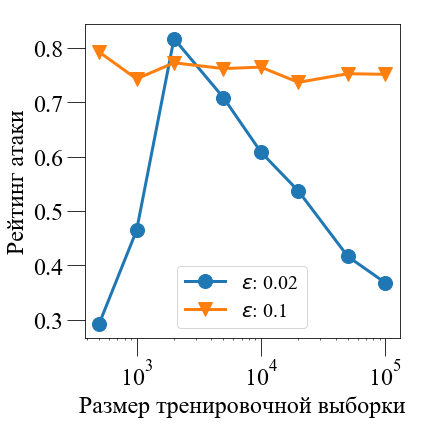

In [36]:
fig, ax = plt.subplots(1, 1)

file = open('plots/{}_by_train_size.csv'.format(name), 'w', newline='')
writer = csv.writer(file, delimiter=',', quotechar=' ')
writer.writerow(['X'] + list(map(str, X)))
fmts = ['o-', 'v-', '^-', 's-', '>-']
for i, y in enumerate(np.array(ys).T):
    label = r'$\epsilon$' + ': {0}'.format(eps_space[i])
    ax.plot(X, y, fmts[i], label=label, markersize=14, lw=3)

    writer.writerow([label] + list(map('{0:6.4F}'.format, y.tolist())))

file.close()

locator = ticker.LogLocator(base=10)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_tick_params(size=18)
ax.yaxis.set_tick_params(size=18)
ax.set_xscale('log')
for xl in ax.get_xticklabels():
    xl.set_fontsize(24)
for yl in ax.get_yticklabels():
    yl.set_fontsize(24)
# ax.set_xticks(X, fontsize=24)
# ax.set_yticks(np.arange(0, 0.7, 0.1), fontsize=24)
ax.legend(fontsize=20)

# plt.title('Fig.1 - Dependence of rate of misclassified images on amplitude, last iteration', loc='bottom')
ax.set_xlabel('Размер тренировочной выборки', fontsize=24)
ax.set_ylabel('Рейтинг атаки', fontsize=24);

plt.tight_layout()
# ax.show()
fig.savefig('plots/{}_by_train_size.png'.format(name), bbox_inches='tight')

